In [69]:
import os
import re
import numpy as np
import pandas as pd
import rasterio
from tqdm import tqdm

# =========================================================
# 1. CẤU HÌNH ĐƯỜNG DẪN & BIẾN
# =========================================================
# Hãy đảm bảo thư mục "DATA_SV" nằm cùng cấp với file notebook này
HIMA_PATH = "../DATA_SV/Hima"
ERA5_PATH = "../DATA_SV/ERA5"
RADAR_PATH = "../DATA_SV/Precipitation/Radar"

OUTPUT_X = "../csv_data/new/x.npy"
OUTPUT_Y = "../csv_data/new/y.npy"

selected_features = ['B04B', 'B10B', 'B11B', 'B16B', 'IRB',
                             'CAPE', 'R850', 'TCWV', 'U850', 'I2B', 'TCLW', 'TCW']


In [70]:

# =========================================================
# 2) TRÍCH DATETIME TỪ FILENAME
# =========================================================
def extract_datetime_from_filename(path):
    filename = os.path.basename(path)

    # -------------------------------------------------------
    # LOẠI 1: ERA5 & RADAR (Có chuỗi 14 số liên tiếp)
    # VD: Radar_20190401000000.tif
    # VD: CAPE_20190401000000.tif
    # -------------------------------------------------------
    m14 = re.search(r"(\d{14})", filename)
    if m14:
        # Format: YYYYMMDDHHMMSS
        return pd.to_datetime(m14.group(1), format="%Y%m%d%H%M%S", errors="coerce")

    # -------------------------------------------------------
    # LOẠI 2: HIMA (Ngày riêng, Giờ riêng sau chữ Z)
    # VD: B04B_20190401.Z0000_TB.tif
    # -------------------------------------------------------
    # Regex logic: Tìm 8 số (ngày) + dấu chấm + chữ Z + 4 số (giờ)
    m_hima = re.search(r"(\d{8})\.Z(\d{4})", filename)
    if m_hima:
        d_str = m_hima.group(1) # 20190401
        t_str = m_hima.group(2) # 0000
        # Ghép lại thành 201904010000
        return pd.to_datetime(d_str + t_str, format="%Y%m%d%H%M", errors="coerce")

    return pd.NaT


# =========================================================
# 3) LIST FILE
# =========================================================
def list_all_files(root):
    out = []
    for dp, _, files in os.walk(root):
        for f in files:
            if f.endswith(".tif") or f.endswith(".TIF"):
                out.append(os.path.join(dp, f))
    return out


def fill_nodata_minus9999(arr):
    """
    Fill toàn bộ NaN / +Inf / -Inf thành -9999
    Nhanh, an toàn cho ML (XGBoost / CatBoost / LGBM)
    """
    arr = arr.astype(np.float32, copy=False)
    mask = np.isnan(arr) | np.isinf(arr)
    if mask.any():
        arr[mask] = -9999.0
    return arr

def get_variable_name(path):
    """
    Lấy tên biến từ filename.
    VD: 'B04B_2019....tif' -> trả về 'B04B'
    VD: 'CAPE_2019....tif' -> trả về 'CAPE'
    """
    filename = os.path.basename(path)
    return filename.split('_')[0]

In [71]:
list_hima = list_all_files(HIMA_PATH)
list_era5 = list_all_files(ERA5_PATH)
list_radar = list_all_files(RADAR_PATH)

list_era5_hima = list_era5 + list_hima

In [72]:
print("số lương file trong HIMA: ",len(list_hima))
print("số lương file trong ERA5: ",len(list_era5))
print("số lương file trong ERA5 + HIMA : ",len(list_era5_hima))

print("số lương file trong RADAR: ",len(list_radar))

số lương file trong HIMA:  33064
số lương file trong ERA5:  58560
số lương file trong ERA5 + HIMA :  91624
số lương file trong RADAR:  2487


In [73]:
def check_common_timestamps(list_hima, list_era5, list_radar):
    """
    Hàm kiểm tra giao thoa thời gian giữa 3 nguồn dữ liệu.
    """
    # 1. Extract timestamps cho HIMA
    print("1. Đang trích xuất thời gian từ HIMA...")
    set_hima = set()
    for p in tqdm(list_hima):
        ts = extract_datetime_from_filename(p)
        if pd.notna(ts):
            set_hima.add(ts)

    # 2. Extract timestamps cho ERA5
    print("2. Đang trích xuất thời gian từ ERA5...")
    set_era5 = set()
    for p in tqdm(list_era5):
        ts = extract_datetime_from_filename(p)
        if pd.notna(ts):
            set_era5.add(ts)

    # 3. Extract timestamps cho RADAR
    print("3. Đang trích xuất thời gian từ RADAR...")
    set_radar = set()
    for p in tqdm(list_radar):
        ts = extract_datetime_from_filename(p)
        if pd.notna(ts):
            set_radar.add(ts)

    # --- THỐNG KÊ ---
    print("\n" + "="*40)
    print(f"Tổng số mốc thời gian HIMA: {len(set_hima)}")
    print(f"Tổng số mốc thời gian ERA5: {len(set_era5)}")
    print(f"Tổng số mốc thời gian RADAR: {len(set_radar)}")

    # --- TÌM GIAO ĐIỂM ---
    common_hima_era5 = set_hima.intersection(set_era5)
    common_all = common_hima_era5.intersection(set_radar)

    print("-" * 40)
    print(f"Giao nhau (HIMA & ERA5): {len(common_hima_era5)}")
    print(f"Giao nhau (ALL 3 nguồn): {len(common_all)}")
    print("="*40)

    # --- DEBUG NẾU KHÔNG CÓ GIAO NHAU ---
    if len(common_all) == 0:
        print("\n⚠️ KHÔNG TÌM THẤY GIAO ĐIỂM! HÃY SO SÁNH MẪU DƯỚI ĐÂY:")
        print("Mẫu HIMA :", sorted(list(set_hima))[:3])
        if len(set_radar) > 0:
            print("Mẫu RADAR:", sorted(list(set_radar))[:3])
        else:
            print("Mẫu RADAR: [Rỗng] -> Kiểm tra lại hàm parse tên file Radar!")

    return sorted(list(common_all))

# --- CHẠY THỬ ---
# Đảm bảo bạn đã có list_hima, list_era5, list_radar từ các cell trước
common_ts = check_common_timestamps(list_hima, list_era5, list_radar)

if len(common_ts) > 0:
    print(f"\n✅ Tìm thấy {len(common_ts)} mốc thời gian chung.")
    print("Ví dụ 5 mốc đầu tiên:", common_ts[:5])
else:
    print("\n❌ Không có mốc thời gian nào chung cả.")

1. Đang trích xuất thời gian từ HIMA...


100%|██████████| 33064/33064 [00:02<00:00, 13732.70it/s]


2. Đang trích xuất thời gian từ ERA5...


100%|██████████| 58560/58560 [00:04<00:00, 14219.73it/s]


3. Đang trích xuất thời gian từ RADAR...


100%|██████████| 2487/2487 [00:00<00:00, 13965.91it/s]


Tổng số mốc thời gian HIMA: 2778
Tổng số mốc thời gian ERA5: 2928
Tổng số mốc thời gian RADAR: 2487
----------------------------------------
Giao nhau (HIMA & ERA5): 2778
Giao nhau (ALL 3 nguồn): 2337

✅ Tìm thấy 2337 mốc thời gian chung.
Ví dụ 5 mốc đầu tiên: [Timestamp('2019-04-01 00:00:00'), Timestamp('2019-04-01 01:00:00'), Timestamp('2019-04-01 02:00:00'), Timestamp('2019-04-01 03:00:00'), Timestamp('2019-04-01 04:00:00')]


In [80]:

def get_final_common_timestamps(list_folders, selected_features):
    """
    Chiến thuật:
    1. Quét TOÀN BỘ file trong 3 folder (bất kể tên gì) để tìm giao điểm thời gian lớn nhất (cái 2337 mốc kia).
    2. Sau khi có bộ khung thời gian chung, đi kiểm tra lại xem những giờ đó có đủ các feature B04B, CAPE... không.
    """

    # --- BƯỚC 1: QUÉT TẤT CẢ ĐỂ LẤY TIMESTAMP CHUNG (như bạn đã làm ra 2337) ---
    print(f"-> [B1] Quét toàn bộ 3 folder để tìm giao điểm thời gian...")
    list_sets = []

    # Biến lưu trữ map: {timestamp: {variable_name: filepath}}
    # Để tí nữa check feature cho nhanh, không cần scan lại
    mega_map = {}

    for folder in list_folders:
        current_ts_set = set()
        print(f"   Scanning: {folder}...")

        for root, _, files in os.walk(folder):
            for f in files:
                if f.lower().endswith(('.tif', '.tiff')):
                    fpath = os.path.join(root, f)
                    ts = extract_datetime_from_filename(fpath)

                    if pd.notna(ts):
                        current_ts_set.add(ts)

                        # Lưu lại thông tin file để dùng cho Bước 2
                        # Lấy prefix làm tên biến (B04B, Radar, CAPE...)
                        var_name = f.split('_')[0]

                        # Mapping tên cho Radar (Quan trọng!)
                        if var_name == 'Radar' or f.startswith('2019') or f.startswith('2020'):
                            var_name = 'y'

                        if ts not in mega_map: mega_map[ts] = set()
                        mega_map[ts].add(var_name)

        list_sets.append(current_ts_set)

    # Giao nhau giữa 3 folder
    if not list_sets: return []
    common_ts = set.intersection(*list_sets)
    sorted_common = sorted(list(common_ts))

    print(f"-> Đã tìm thấy {len(sorted_common)} mốc thời gian chung (Raw Intersection).")

    # --- BƯỚC 2: LỌC LẠI THEO FEATURE ---
    # Bây giờ ta chỉ giữ lại những mốc thời gian mà tại đó có ĐỦ các feature yêu cầu

    print(f"-> [B2] Kiểm tra tính đầy đủ của Feature...")
    print(f"   Yêu cầu: {selected_features} + ['y']")

    final_valid_ts = []

    # Input feature + y
    required_set = set(selected_features + ['y'])

    for ts in sorted_common:
        # Lấy danh sách các biến CÓ MẶT tại thời điểm ts
        vars_at_ts = mega_map.get(ts, set())

        # Kiểm tra xem có chứa đủ bộ required không
        # Lưu ý: vars_at_ts có thể chứa nhiều biến rác khác, ta chỉ quan tâm nó có chứa đủ bộ required không thôi
        if required_set.issubset(vars_at_ts):
            final_valid_ts.append(ts)

    print("\n" + "="*40)
    print(f"✅ KẾT QUẢ CUỐI CÙNG: {len(final_valid_ts)} mốc thời gian ĐỦ DỮ LIỆU.")
    print("="*40)

    if len(final_valid_ts) == 0 and len(sorted_common) > 0:
        print("⚠️ CẢNH BÁO: Có giao điểm thời gian nhưng bị thiếu Feature!")
        # Debug thử 1 mẫu
        sample_ts = sorted_common[0]
        print(f"   Tại {sample_ts} có các biến: {mega_map[sample_ts]}")
        print(f"   Thiếu: {required_set - mega_map[sample_ts]}")

    return final_valid_ts


In [81]:

# =========================================================
# CHẠY
# =========================================================
if __name__ == "__main__":
    FOLDERS = [HIMA_PATH, ERA5_PATH, RADAR_PATH]

    # Feature list
    FEATURES = ['B04B', 'B10B', 'B11B', 'B16B', 'IRB',
                'CAPE', 'R850', 'TCWV', 'U850', 'I2B', 'TCLW', 'TCW']

    # Chạy
    final_timestamps = get_final_common_timestamps(FOLDERS, FEATURES)

-> [B1] Quét toàn bộ 3 folder để tìm giao điểm thời gian...
   Scanning: ../DATA_SV/Hima...
   Scanning: ../DATA_SV/ERA5...
   Scanning: ../DATA_SV/Precipitation/Radar...
-> Đã tìm thấy 2337 mốc thời gian chung (Raw Intersection).
-> [B2] Kiểm tra tính đầy đủ của Feature...
   Yêu cầu: ['B04B', 'B10B', 'B11B', 'B16B', 'IRB', 'CAPE', 'R850', 'TCWV', 'U850', 'I2B', 'TCLW', 'TCW'] + ['y']

✅ KẾT QUẢ CUỐI CÙNG: 1223 mốc thời gian ĐỦ DỮ LIỆU.


In [82]:
# =========================================================
# 2. HÀM CHÍNH: TIF -> DATAFRAME -> NUMPY
# =========================================================
def process_tif_to_numpy(list_folders, input_features):
    """
    Quy trình 3 bước:
    1. Scan file -> DataFrame
    2. Filter DataFrame (chỉ giữ giờ đủ biến)
    3. Read Tif -> Numpy Array [Time, Band, Row, Col]
    """

    # Danh sách biến bắt buộc: Features + y
    required_vars = sorted(input_features + ['y'])
    print(f"-> Yêu cầu bộ biến ({len(required_vars)}): {required_vars}")

    # ---------------------------------------------------------
    # BƯỚC 1: QUÉT FILE VÀ TẠO DATAFRAME
    # ---------------------------------------------------------
    print("[B1] Tạo DataFrame Metadata từ các folder...")
    records = []

    for folder in list_folders:
        for root, _, files in os.walk(folder):
            for f in files:
                if f.lower().endswith(('.tif', '.tiff')):
                    fpath = os.path.join(root, f)
                    ts = extract_datetime_from_filename(fpath)

                    if pd.notna(ts):
                        # --- Logic Mapping tên biến ---
                        var_name = f.split('_')[0] # Lấy prefix

                        # Radar/2019/2020 -> y
                        if var_name == 'Radar' or f.startswith('2019') or f.startswith('2020'):
                            var_name = 'y'

                        # Chỉ lấy nếu biến thuộc danh sách cần thiết
                        if var_name in required_vars:
                            records.append({
                                "timestamp": ts,
                                "variable": var_name,
                                "filepath": fpath
                            })

    df = pd.DataFrame(records)
    if df.empty:
        print("❌ Lỗi: Không tìm thấy file nào!")
        return None, None

    # ---------------------------------------------------------
    # BƯỚC 2: LỌC VÀ SẮP XẾP DATAFRAME
    # ---------------------------------------------------------
    print(f"[B2] Lọc dữ liệu (Tổng {len(df)} file ban đầu)...")

    # Đếm số biến mỗi giờ
    counts = df.groupby("timestamp")["variable"].nunique()

    # Lấy các timestamp có đủ số lượng biến required
    valid_ts = counts[counts == len(required_vars)].index.sort_values().tolist()
    print(f"-> Tìm thấy {len(valid_ts)} khung giờ ĐỦ bộ dữ liệu.")

    if len(valid_ts) == 0:
        return None, None

    # Lọc DataFrame chỉ giữ lại các dòng hợp lệ
    df_clean = df[df["timestamp"].isin(valid_ts)].copy()

    # QUAN TRỌNG: Sort để đảm bảo thứ tự index trong Numpy không bị loạn
    # Sort theo Time tăng dần -> Variable A-Z
    df_clean.sort_values(by=["timestamp", "variable"], inplace=True)

    # ---------------------------------------------------------
    # BƯỚC 3: ĐỔ VÀO NUMPY ARRAY [Time][Band][Row][Col]
    # ---------------------------------------------------------

    # Lấy kích thước ảnh từ file đầu tiên
    sample_path = df_clean.iloc[0]['filepath']
    with rasterio.open(sample_path) as src:
        H, W = src.shape

    n_times = len(valid_ts)
    n_bands = len(required_vars)

    print(f"[B3] Khởi tạo Tensor ({n_times}, {n_bands}, {H}, {W})...")

    # Khởi tạo mảng 4D với -9999
    tensor = np.full((n_times, n_bands, H, W), -9999.0, dtype=np.float32)

    # Tạo mapping để biết điền vào index nào
    # Time map: Timestamp -> 0, 1, 2...
    t_map = {ts: i for i, ts in enumerate(valid_ts)}
    # Band map: Variable Name -> 0, 1, 2...
    b_map = {v: i for i, v in enumerate(required_vars)}

    print("-> Đang đọc pixel từ file...")
    # Loop qua từng dòng của DataFrame (đã sort)
    for _, row in tqdm(df_clean.iterrows(), total=len(df_clean)):
        t_idx = t_map[row['timestamp']]
        b_idx = b_map[row['variable']]
        path = row['filepath']

        try:
            with rasterio.open(path) as src:
                data = src.read(1)
                # Xử lý nodata gốc
                if src.nodata is not None:
                    data[data == src.nodata] = np.nan

                # Fill -9999 và gán vào tensor
                tensor[t_idx, b_idx, :, :] = fill_nodata_minus9999(data)

        except Exception as e:
            print(f"Err {path}: {e}")

    # ---------------------------------------------------------
    # TÁCH X VÀ Y
    # ---------------------------------------------------------
    y_idx = b_map['y']
    x_indices = [i for i, v in enumerate(required_vars) if v != 'y']

    X = tensor[:, x_indices, :, :]
    y = tensor[:, [y_idx], :, :] # Giữ 4 chiều (T, 1, H, W)

    # Feature names ứng với các kênh của X
    final_features = [required_vars[i] for i in x_indices]

    return X, y, valid_ts, final_features

# =========================================================
# CHẠY THỰC TẾ
# =========================================================
if __name__ == "__main__":
    # 1. Input Folders
    FOLDERS = [HIMA_PATH, ERA5_PATH, RADAR_PATH]

    # 2. Input Features (Không cần 'y', hàm tự thêm)
    FEATURES = ['B04B', 'B10B', 'B11B', 'B16B', 'IRB', 'I2B',
                'CAPE', 'R850', 'TCWV', 'U850', 'TCLW', 'TCW']

    # 3. Thực thi
    X, y, times, feats = process_tif_to_numpy(FOLDERS, FEATURES)

    if X is not None:
        print("\n--- KẾT QUẢ ---")
        print(f"X shape: {X.shape}") # (1223, 12, H, W)
        print(f"y shape: {y.shape}") # (1223, 1, H, W)
        print(f"Thứ tự Feature trong X: {feats}")

        # Lưu file
        np.save("../csv_data/new/x.npy", X)
        np.save("../csv_data/new/y.npy", y)
        print("Đã lưu xong.")

-> Yêu cầu bộ biến (13): ['B04B', 'B10B', 'B11B', 'B16B', 'CAPE', 'I2B', 'IRB', 'R850', 'TCLW', 'TCW', 'TCWV', 'U850', 'y']
[B1] Tạo DataFrame Metadata từ các folder...
[B2] Lọc dữ liệu (Tổng 35375 file ban đầu)...
-> Tìm thấy 1223 khung giờ ĐỦ bộ dữ liệu.
[B3] Khởi tạo Tensor (1223, 13, 90, 250)...
-> Đang đọc pixel từ file...


100%|██████████| 15899/15899 [00:30<00:00, 517.31it/s]



--- KẾT QUẢ ---
X shape: (1223, 12, 90, 250)
y shape: (1223, 1, 90, 250)
Thứ tự Feature trong X: ['B04B', 'B10B', 'B11B', 'B16B', 'CAPE', 'I2B', 'IRB', 'R850', 'TCLW', 'TCW', 'TCWV', 'U850']
Đã lưu xong.


In [84]:
x = np.load("../csv_data/new/x.npy")
y = np.load("../csv_data/new/y.npy")

In [85]:
print(x.shape)
print(y.shape)

(1223, 12, 90, 250)
(1223, 1, 90, 250)


In [86]:
# Cách 2 (an toàn hơn nếu sợ squeeze nhầm): Lấy trực tiếp
y_new = y[:, 0, :, :]

print(f"Shape mới: {y_new.shape}") # (1223, 500, 500)

# Lưu lại
np.save("../csv_data/new/y.npy", y_new)
print("✅ Đã lưu đè file y.npy thành công với 3 chiều!")

Shape mới: (1223, 90, 250)
✅ Đã lưu đè file y.npy thành công với 3 chiều!


In [87]:
y = np.load("../csv_data/new/y.npy")


In [88]:
print(y.shape)

(1223, 90, 250)


--- Đang vẽ mẫu thứ: 24 / 1223 ---


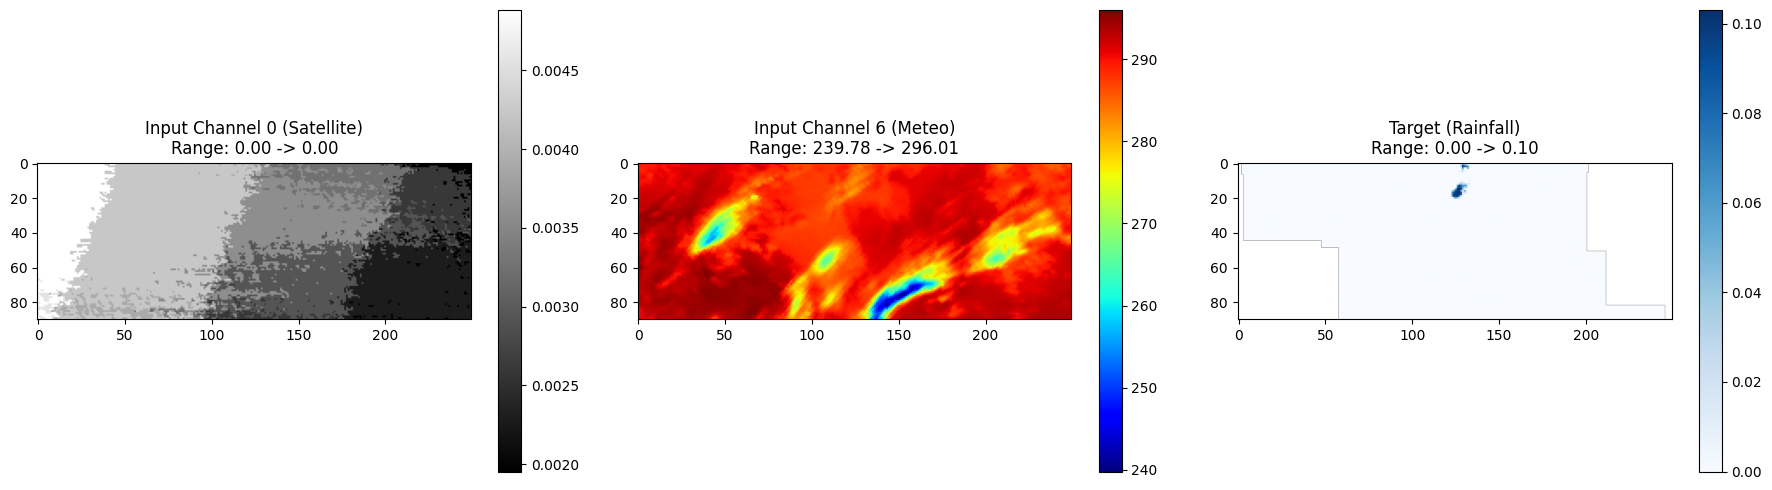

In [89]:
import matplotlib.pyplot as plt
import random
def plot_data_check(x, y, sample_index=None):
    """
    Hàm vẽ kiểm tra dữ liệu từ biến x, y có sẵn.
    x: (Time, Channels, H, W)
    y: (Time, H, W) hoặc (Time, 1, H, W)
    """
    # 1. Kiểm tra shape y, nếu 4 chiều thì ép về 3 chiều để dễ plot
    if y.ndim == 4:
        y_plot = y[:, 0, :, :]
    else:
        y_plot = y

    # 2. Chọn index ngẫu nhiên nếu không truyền vào
    total_samples = x.shape[0]
    if sample_index is None:
        sample_index = random.randint(0, total_samples - 1)

    print(f"--- Đang vẽ mẫu thứ: {sample_index} / {total_samples} ---")

    # 3. Lấy dữ liệu tại index đó
    # Kênh 0 (Thường là B04B - Vệ tinh)
    feat_sat = x[sample_index, 0, :, :]

    # Kênh giữa (Thường là ERA5 - Khí tượng, ví dụ CAPE/R850)
    mid_idx = x.shape[1] // 2
    feat_meteo = x[sample_index, mid_idx, :, :]

    # Target (Mưa)
    target = y_plot[sample_index, :, :]

    # 4. Mask giá trị -9999 (Để không làm hỏng thang màu)
    feat_sat = np.ma.masked_equal(feat_sat, -9999.0)
    feat_meteo = np.ma.masked_equal(feat_meteo, -9999.0)
    target = np.ma.masked_equal(target, -9999.0)

    # 5. Vẽ hình
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Hình 1: Vệ tinh (Gray scale)
    im1 = axes[0].imshow(feat_sat, cmap='gray')
    axes[0].set_title(f"Input Channel 0 (Satellite)\nRange: {feat_sat.min():.2f} -> {feat_sat.max():.2f}")
    plt.colorbar(im1, ax=axes[0])

    # Hình 2: Khí tượng (Jet scale)
    im2 = axes[1].imshow(feat_meteo, cmap='jet')
    axes[1].set_title(f"Input Channel {mid_idx} (Meteo)\nRange: {feat_meteo.min():.2f} -> {feat_meteo.max():.2f}")
    plt.colorbar(im2, ax=axes[1])

    # Hình 3: Mưa (Blue scale)
    im3 = axes[2].imshow(target, cmap='Blues')
    axes[2].set_title(f"Target (Rainfall)\nRange: {target.min():.2f} -> {target.max():.2f}")
    plt.colorbar(im3, ax=axes[2])

    plt.tight_layout()
    plt.show()


plot_data_check(x, y)

In [90]:
print("=== KIỂM TRA GIÁ TRỊ -9999 ===")

# 1. Kiểm tra X
num_missing_x = np.sum(x == -9999)
print(f"X có {num_missing_x} giá trị -9999 (chiếm {num_missing_x/x.size:.2%})")

# 2. Kiểm tra y
num_missing_y = np.sum(y == -9999)
print(f"y có {num_missing_y} giá trị -9999 (chiếm {num_missing_y/y.size:.2%})")

=== KIỂM TRA GIÁ TRỊ -9999 ===
X có 0 giá trị -9999 (chiếm 0.00%)
y có 7632719 giá trị -9999 (chiếm 27.74%)
